#Download Data

In [ ]:
!wget https://cdn.discordapp.com/attachments/778630432878362676/934217772664258560/MultiTest.rar
!wget https://cdn.discordapp.com/attachments/778630432878362676/934217856114122752/MultiDev.rar
!wget https://cdn.discordapp.com/attachments/778630432878362676/934217865811349504/MultiTrain.Shuffled.rar

In [ ]:
!unrar x "/content/MultiDev.rar" "/content/Data/"
!unrar x "/content/MultiTest.rar" "/content/Data/"
!unrar x "/content/MultiTrain.Shuffled.rar" "/content/Data/"

#Imports

In [3]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
!pip install -q transformers
!pip install -q datasets
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from datasets import load_metric
!pip install ar_wordcloud
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.graph_objs as go 
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np        
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
import pandas as pd
from ar_wordcloud import ArabicWordCloud
from PIL import Image

#Data Analysis

In [ ]:
!wget https://cdn.discordapp.com/attachments/778630432878362676/934885022710771832/df_dev_cleaned.csv

In [ ]:
data = pd.read_csv("/content/df_dev_cleaned.csv")

In [ ]:
dialects = ['MSA' ,'DIAL_GLF' , 'DIAL_EGY' ,'DIAL_LEV']
sizes = []
for dialect in dialects:
  size = len(Train[Train['label'] == dialect])
  sizes.append(size)
dialects = ['MSA' ,'GULF' , 'EGYPT' ,'Levantine']

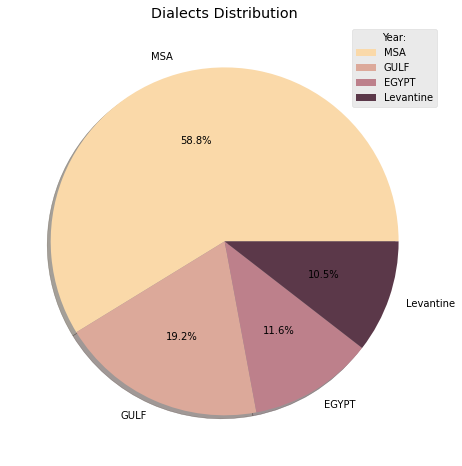

In [ ]:
y = sizes
mylabels = dialects
mycolors = ["#FAD9A9", "#DCA99A", "#BD808B","#5B3849"]
plt.pie(y, labels = dialects ,colors=mycolors, shadow = True, autopct='%1.1f%%',labeldistance=1.1)
plt.legend(title = "Year:")
plt.title('Dialects Distribution')
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [ ]:
GULF = data[data['label'] == 'DIAL_GLF'].text.tolist()
MSA = data[data['label'] == 'MSA'].text.tolist()
Lev = data[data['label'] =='DIAL_LEV'].text.tolist()
Egy = data[data['label'] == 'DIAL_EGY'].text.tolist()

In [ ]:
def generate_wc(data,w,h,name):
  text_list = [str(sen).split() for sen in data]
  text_list = [item for sublist in text_list for item in sublist]
  text_list_unique = list(set(text_list))
  words_string = " ".join(text_list_unique)+" "
  word_cloud = ArabicWordCloud(background_color="white",width=w,height=h)
  wc = word_cloud.from_text(words_string)
  wc.to_file(name+".png")

***Gulf Dialect Word Cloud***

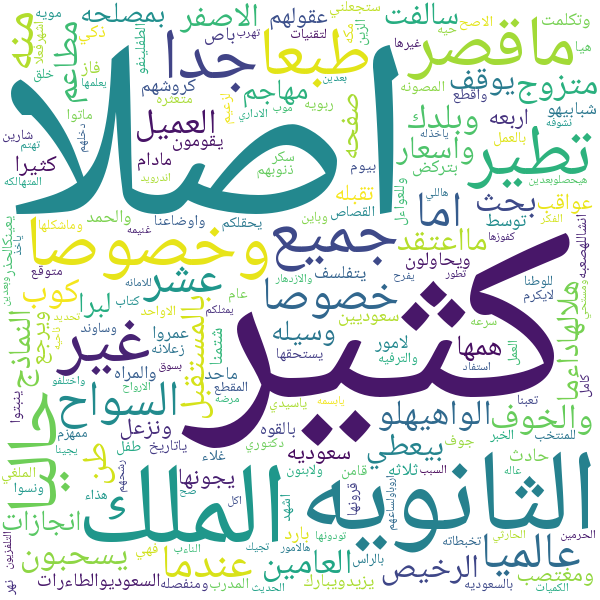

In [ ]:
generate_wc(GULF,600,600,"GULF")
Image.open('/content/GULF.png')

***Egypt Dialect Word Cloud***

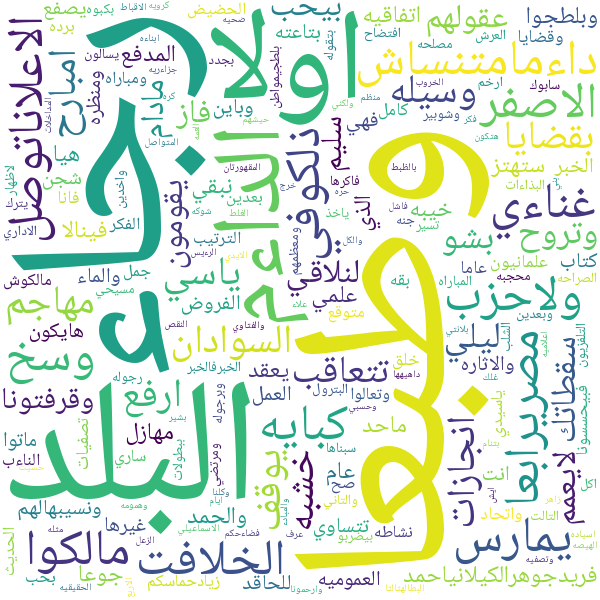

In [ ]:
generate_wc(Egy,600,600,"EGY")
Image.open('/content/EGY.png')

***Lev Dialect Word Cloud***

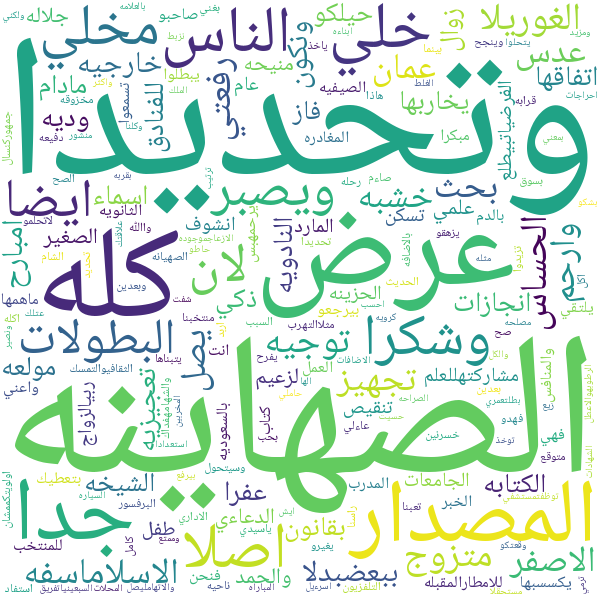

In [ ]:
generate_wc(Lev,600,600,"LEV")
Image.open('/content/LEV.png')

***MSA Word Dialect***

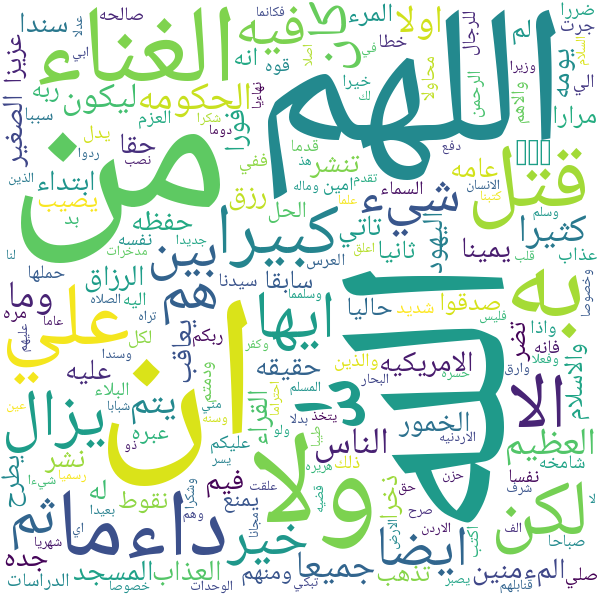

In [ ]:
generate_wc(MSA,600,600,"MSA")
Image.open('/content/MSA.png')

#Preprocessing

In [4]:
Corpus="/content/Data/MultiTrain.Shuffled.csv"
Devset="/content/Data/MultiDev.csv"
Testset="/content/Data/MultiTest.csv"

In [5]:
df_train = pd.read_csv(Corpus)
df_dev = pd.read_csv(Devset)
df_test = pd.read_csv(Testset)

In [6]:
df_train.dropna(inplace=True)
df_dev.dropna(inplace=True)
df_test.dropna(inplace=True)

df_train.drop_duplicates(subset=['text'] , keep="first",inplace=True)
df_dev.drop_duplicates(subset=['text'] , keep="first",inplace=True)
df_test.drop_duplicates(subset=['text'] , keep="first",inplace=True)

In [7]:
stop_words =['من',
 'في',
 'على',
 'و',
 'فى',
 'يا',
 'عن',
 'مع',
 'ان',
 'هو',
 'علي',
 'ما',
 'اللي',
 'كل',
 'بعد',
 'ده',
 'اليوم',
 'أن',
 'يوم',
 'انا',
 'إلى',
 'كان',
 'ايه',
 'اللى',
 'الى',
 'دي',
 'بين',
 'انت',
 'أنا',
 'حتى',
 'لما',
 'فيه',
 'هذا',
 'واحد',
 'احنا',
 'اي',
 'كده',
 'إن',
 'او',
 'أو',
 'عليه',
 'ف',
 'دى',
 'مين',
 'الي',
 'كانت',
 'أمام',
 'زي',
 'يكون',
 'خلال',
 'ع',
 'كنت',
 'هي',
 'فيها',
 'عند',
 'التي',
 'الذي',
 'قال',
 'هذه',
 'قد',
 'انه',
 'ريتويت',
 'بعض',
 'أول',
 'ايه',
 'الان',
 'أي',
 'منذ',
 'عليها',
 'له',
 'ال',
 'تم',
 'ب',
 'دة',
 'عليك',
 'اى',
 'كلها',
 'اللتى',
 'هى',
 'دا',
 'انك',
 'وهو',
 'ومن',
 'منك',
 'نحن',
 'زى',
 'أنت',
 'انهم',
 'معانا',
 'حتي',
 'وانا',
 'عنه',
 'إلي',
 'ونحن',
 'وانت',
 'منكم',
 'وان',
 'معاهم',
 'معايا',
 'وأنا',
 'عنها',
 'إنه',
 'اني',
 'معك',
 'اننا',
 'فيهم',
 'د',
 'انتا',
 'عنك',
 'وهى',
 'معا',
 'آن',
 "لذلك",
 'انتي',
 'وأنت',
 'وإن',
 'ومع',
 'وعن',
 'معاكم',
 'معاكو',
 'معاها',
 'وعليه',
 'وانتم',
 'وانتي',
 '¿',
 '|']

In [8]:
punct_pattern = (
    r"([!\"#\$%\'\(\)\*\+,\.:;\-<&=·>?@\[\\\]\^_ـ`{\|}~—٪’،؟`୍“؛”ۚ【»؛\s+«–…‘]{2,})"
)

In [9]:
def normalize(sentence):
    '''
    Argument:
        string of words
    return:
        string of words but standardize the words
    '''
    sentence = re.sub("[إأآا]", "ا", sentence)
    sentence = re.sub("ى", "ي", sentence)
    sentence = re.sub("ؤ", "ء", sentence)
    sentence = re.sub("ئ", "ء", sentence)
    sentence = re.sub("ة", "ه", sentence)
    sentence = re.sub("گ", "ك", sentence)
    return sentence

In [10]:
def removing_ar_stopwords(text):
    """
        Here we remove all Arabic stop words
        
    """
    original_words = []
    words = word_tokenize(text) 
    for word in words:
        if word not in stop_words:
            original_words.append(word)
    filtered_sentence = " ".join(original_words)
    return filtered_sentence

In [11]:
def remove_punkt_num(sentence):
  '''
    Argument:
        string of words
    return:
        string of words but after removing punctuations and digits
  '''
  text = re.sub(punct_pattern,"",sentence)
  text = re.sub("[0123456789]","",text)
  return text

In [12]:
def preprocess(data):
  '''
    Argument:
        string of words as a dataframe
    return:
        a cleaned dataframe after applying preprocessing
  '''
  cleared_tweet_1 = []       
  cleared_tweet_1_2 = []         
  cleared_tweet_1_2_3 = []       

  data_text = data['text'].tolist()

  for tweet in data_text: 
    cleared_tweet_1.append(removing_ar_stopwords(tweet))        

  for tweets in cleared_tweet_1:
    cleared_tweet_1_2.append(normalize(tweets))                
                              
  for tweetss in cleared_tweet_1_2:
    cleared_tweet_1_2_3.append(remove_punkt_num(tweetss)) 

  data['text'] = cleared_tweet_1_2_3

  return data

In [13]:
df_train_cleaned = preprocess(df_train)
df_dev_cleaned = preprocess(df_dev)
df_test_cleaned = preprocess(df_test)

In [14]:
df_test_cleaned.drop(columns=['Unnamed: 0'] , inplace=True)
df_dev_cleaned.drop(columns=['Unnamed: 0'] , inplace=True)  
df_train_cleaned.drop(columns=['Unnamed: 0'] , inplace=True) 

In [15]:
df_train_cleaned.head()

,label,text
0,MSA,بالاضافه لقيام معلمو الجيزه للذهاب جريده الساب...
1,MSA,بعدين والله حرام تجي تلقي واقف الاشاره بالعرض ...
2,DIAL_LEV,لمسه اليد مرتين واضحه جدا والحكم
3,DIAL_LEV,بخصوص الهاتريك عمرها راح تصير
4,DIAL_GLF,الله يجبر كسرهم ويرجع لدهم قبل بكري


In [16]:
df_dev_cleaned.head()

,label,text
0,DIAL_EGY,تصور كلهتلاقيني باحبك اكتر
1,DIAL_EGY,اكتر روحي باحبك
2,DIAL_EGY,وتصور حب المخلص لحبيبه ولا بايه يتغير
4,DIAL_EGY,اكتر روحي باحبكبحقيقي باحبك اكتر
5,DIAL_EGY,وغنايا بكلمه احبك بالنسبه لدرجه حبك رمز صغير م...


In [17]:
df_test_cleaned.head()

,label,text
0,DIAL_EGY,ياراجل فن هوه فن قله
1,DIAL_EGY,حاجه تكسف مش كفايه روبي كمان
2,DIAL_EGY,اللهم صبرنا ابتليتنا به مناظركم زودت القرف بنش...
3,DIAL_EGY,ارحمونه الفن خرب الاقارب والعالم
5,DIAL_EGY,الاخت روبي مش مكفيها عاملاه جايبه لنا اختها ال...


In [18]:
df_train_cleaned.to_csv("df_train_cleaned.csv",index=False)
df_dev_cleaned.to_csv("df_dev_cleaned.csv",index=False)
df_test_cleaned.to_csv("df_test_cleaned.csv",index=False)

#ARABERT

In [19]:
BERT_MODEL_NAME = 'aubmindlab/bert-base-arabertv02-twitter'

In [20]:
dialects = df_train_cleaned['label'].unique()
lbl2idx = {d: i for i, d in enumerate(dialects)}

In [21]:
df_train_cleaned['label'].unique()

array(['MSA', 'DIAL_LEV', 'DIAL_GLF', 'DIAL_EGY'], dtype=object)

In [22]:
df_train_cleaned['label'] = df_train_cleaned['label'].map(lbl2idx)
df_test_cleaned['label'] = df_test_cleaned['label'].map(lbl2idx)
df_dev_cleaned['label'] = df_dev_cleaned['label'].map(lbl2idx)

In [23]:
df_train_cleaned.head()

,label,text
0,0,بالاضافه لقيام معلمو الجيزه للذهاب جريده الساب...
1,0,بعدين والله حرام تجي تلقي واقف الاشاره بالعرض ...
2,1,لمسه اليد مرتين واضحه جدا والحكم
3,1,بخصوص الهاتريك عمرها راح تصير
4,2,الله يجبر كسرهم ويرجع لدهم قبل بكري


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=4)

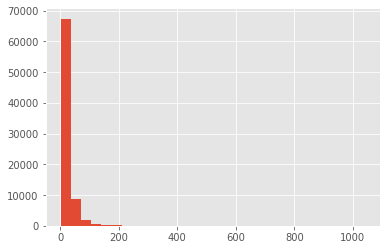

In [25]:
seq_len = [len(tokenizer.encode(i)) for i in df_train_cleaned['text']]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
# seq_len_all = []
# for tweet in df_train_cleaned['text']:
#   t = tweet.split()
#   seq_len = len(t)
#   if seq_len == 764:
#     tt = tweet
#     continue
#   seq_len_all.append(seq_len)
# print(max(seq_len_all))

In [26]:
max_seq_len = 60

In [27]:
train_encodings = tokenizer(df_train_cleaned['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(df_dev_cleaned['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(df_test_cleaned['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [28]:
train_labels = df_train_cleaned['label']
val_labels = df_dev_cleaned['label']
test_labels = df_test_cleaned['label']

In [29]:
class TweetDataset(Dataset):
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels.to_list()

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [ ]:
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## Train

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=2,              
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,              
    evaluation_strategy='epoch',
    # load_best_model_at_end=True
    )

trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics=compute_metrics
)

trainer.train()

***** Running training *****
  Num examples = 79313
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4958


Epoch,Training Loss,Validation Loss,Accuracy
1,0.486200,0.445275,0.837902
2,0.329300,0.470467,0.844882


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 9741
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to 

TrainOutput(global_step=4958, training_loss=0.4284690958494715, metrics={'train_runtime': 1915.544, 'train_samples_per_second': 82.81, 'train_steps_per_second': 2.588, 'total_flos': 4891055125020480.0, 'train_loss': 0.4284690958494715, 'epoch': 2.0})

In [ ]:
preds = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 10197
  Batch size = 64


##Save Best model checkpoint

In [ ]:
!cp -r /content/results/checkpoint-1500 /content/drive/MyDrive/checkpoint-1500acc-853/

##Load model from Checkpoint

In [ ]:
Model_checkpoint = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/checkpoint-1500acc-853/")
inf_trainer = Trainer(
    model=Model_checkpoint,                       
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,           
    compute_metrics=compute_metrics
)
preds = inf_trainer.predict(test_dataset)

In [ ]:
preds

PredictionOutput(predictions=array([[-0.04110702, -1.4013013 ,  0.48359302,  0.5200489 ],
       [-2.4320822 , -0.6209899 , -1.1690421 ,  4.1553497 ],
       [-2.0793595 ,  0.4046763 , -0.13772349,  1.8340958 ],
       ...,
       [ 3.8351223 , -1.4604143 , -1.0918577 , -2.0393846 ],
       [ 1.744842  , -1.2459086 ,  0.9485436 , -2.3119168 ],
       [ 4.3558145 , -2.119544  , -0.14534292, -2.71839   ]],
      dtype=float32), label_ids=array([3, 3, 3, ..., 0, 0, 0]), metrics={'test_loss': 0.4204847514629364, 'test_accuracy': 0.853486319505737, 'test_runtime': 36.7418, 'test_samples_per_second': 277.532, 'test_steps_per_second': 4.355})

##Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [34]:
training_args = TrainingArguments(
    output_dir='./results',        
    num_train_epochs=2,            
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=64,  
    warmup_steps=500,                
    weight_decay=0.01,               
    evaluation_strategy='epoch',
    )

In [33]:
Ara_Model_checkpoint = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/checkpoint-1500acc-853/")

In [35]:
Ara_inf_trainer = Trainer(
    model=Ara_Model_checkpoint,                        
    args=training_args,                        
    compute_metrics=compute_metrics
)
Ara_preds = Ara_inf_trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 10197
  Batch size = 64


In [36]:
Ara_preds

PredictionOutput(predictions=array([[-0.04110705, -1.4013015 ,  0.48359358,  0.5200489 ],
       [-2.4320831 , -0.62099075, -1.1690421 ,  4.1553516 ],
       [-2.0793617 ,  0.40467557, -0.13772312,  1.8340968 ],
       ...,
       [ 3.835121  , -1.4604156 , -1.0918573 , -2.0393844 ],
       [ 1.7448425 , -1.24591   ,  0.94854414, -2.3119183 ],
       [ 4.3558164 , -2.1195455 , -0.14534338, -2.718388  ]],
      dtype=float32), label_ids=array([3, 3, 3, ..., 0, 0, 0]), metrics={'test_loss': 0.4204847514629364, 'test_accuracy': 0.853486319505737, 'test_runtime': 87.58, 'test_samples_per_second': 116.431, 'test_steps_per_second': 1.827})

In [101]:
print("Accuracy = ",Ara_preds[2]['test_accuracy'] * 100)

Accuracy =  85.34863195057369


In [37]:
def predict(Trainer,tokenizer,sentence):
  labels_dict = { 3:'DIAL_EGY', 2:'DIAL_GLF', 1:'DIAL_LEV', 0:'MSA'}
  data = [[0, sentence]]
  df = pd.DataFrame(data, columns = ['label', 'text'])
  test_labels = df['label']
  test_encodings = tokenizer(df['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
  test_dataset = TweetDataset(test_encodings, test_labels)
  pred = Trainer.predict(test_dataset)
  pred = np.argmax(pred[0],axis=-1)
  return labels_dict[pred[0]]

In [38]:
predict(Ara_inf_trainer,tokenizer,"ياراجل فن هوه فن قله")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'DIAL_EGY'

In [40]:
predict(Ara_inf_trainer,tokenizer,"شو بدك")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'DIAL_LEV'

In [43]:
predict(Ara_inf_trainer,tokenizer,"ايش تريدي")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'DIAL_GLF'

In [44]:
predict(Ara_inf_trainer,tokenizer,"لدي استفسار الرجاء")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'MSA'

#MARBERT

In [54]:
df_train_cleaned = pd.read_csv("/content/df_train_cleaned.csv")
df_dev_cleaned = pd.read_csv("/content/df_dev_cleaned.csv")
df_test_cleaned = pd.read_csv("/content/df_test_cleaned.csv")

In [57]:
BERT_MODEL_NAME = 'UBC-NLP/MARBERT'
max_seq_len = 60

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)
mar_tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

In [59]:
dialects = df_train_cleaned['label'].unique()
lbl2idx = {d: i for i, d in enumerate(dialects)}

In [60]:
df_train_cleaned['label'] = df_train_cleaned['label'].map(lbl2idx)
df_test_cleaned['label'] = df_test_cleaned['label'].map(lbl2idx)
df_dev_cleaned['label'] = df_dev_cleaned['label'].map(lbl2idx)

In [65]:
def s(t):
  return str(t)

In [68]:
df_train_cleaned['text'] = df_train_cleaned['text'].apply(s)
df_test_cleaned['text'] = df_test_cleaned['text'].apply(s)
df_dev_cleaned['text'] = df_dev_cleaned['text'].apply(s)

In [69]:
train_encodings = mar_tokenizer(df_train_cleaned['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = mar_tokenizer(df_dev_cleaned['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = mar_tokenizer(df_test_cleaned['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [71]:
train_labels = df_train_cleaned['label']
val_labels = df_dev_cleaned['label']
test_labels = df_test_cleaned['label']

In [73]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset_mar = TweetDataset(train_encodings, train_labels)
val_dataset_mar = TweetDataset(val_encodings, val_labels)
test_dataset_mar = TweetDataset(test_encodings, test_labels)

In [74]:
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

##Train

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=2,          
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,  
    warmup_steps=500,               
    weight_decay=0.01,           
    evaluation_strategy='epoch',
    # load_best_model_at_end=True
    )

trainer = Trainer(
    model=model,                      
    args=training_args,                 
    train_dataset=train_dataset_mar,       
    eval_dataset=val_dataset_mar,         
    compute_metrics=compute_metrics
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 79313
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4958


Epoch,Training Loss,Validation Loss,Accuracy
1,0.512000,0.511311,0.815214
2,0.283500,0.525870,0.834001


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 9741
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to 

TrainOutput(global_step=4958, training_loss=0.4273846585118708, metrics={'train_runtime': 1989.8857, 'train_samples_per_second': 79.716, 'train_steps_per_second': 2.492, 'total_flos': 4891099039042320.0, 'train_loss': 0.4273846585118708, 'epoch': 2.0})

In [ ]:
# preds = trainer.predict(test_dataset)
# preds_labels = [ np.argmax(i, axis=-1) for i  in preds[0]]
# sum = 0
# for i in range(10197):
#   if preds_labels[i] == test_dataset.labels[i]:
#     sum+=1
# sum/10197

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/results/checkpoint-1500 /content/drive/MyDrive/checkpoint-1500-MARBERT-850/

##Best Checkpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
Inf_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/checkpoint-1500-MARBERT-850/", num_labels=5)
Inf_trainer = Trainer(
    model=Inf_model,                        
    args=training_args,                 
    train_dataset=train_dataset,    
    eval_dataset=val_dataset,           
    compute_metrics=compute_metrics
)

In [ ]:
Inf_trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 10197
  Batch size = 64


PredictionOutput(predictions=array([[ 0.7688362 , -0.83592665,  0.37525764,  3.2989686 , -3.8410623 ],
       [-0.13872989, -0.96453476, -0.49011555,  4.5424695 , -2.6891935 ],
       [ 0.1839789 ,  0.52382   ,  0.58886075,  2.618954  , -4.267729  ],
       ...,
       [ 3.687369  ,  0.5032038 ,  0.65345275, -1.4883766 , -4.2793684 ],
       [ 2.3587449 ,  0.536398  ,  2.2027776 , -1.4260201 , -4.7381954 ],
       [ 4.1297693 , -0.67868155,  1.3852931 , -2.2140908 , -3.588495  ]],
      dtype=float32), label_ids=array([3, 3, 3, ..., 0, 0, 0]), metrics={'test_loss': 0.4435162842273712, 'test_accuracy': 0.8500539374325782, 'test_runtime': 35.0418, 'test_samples_per_second': 290.995, 'test_steps_per_second': 4.566})

##Inference

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',        
    num_train_epochs=2,            
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=64,  
    warmup_steps=500,                
    weight_decay=0.01,               
    evaluation_strategy='epoch',
    )

In [ ]:
Mar_Model_checkpoint = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/checkpoint-1500-MARBERT-850/")

In [85]:
Mar_inf_trainer = Trainer(
    model=Mar_Model_checkpoint,                      
    args=training_args,             
    compute_metrics=compute_metrics
)
Mar_preds = Mar_inf_trainer.predict(test_dataset_mar)

***** Running Prediction *****
  Num examples = 10197
  Batch size = 64


In [81]:
print("Accuracy = ",Mar_preds[2]['test_accuracy']*100)

Accuracy =  84.7994508188683


In [102]:
def predict(Trainer,tokenizer,sentence):
  labels_dict = { 3:'DIAL_EGY', 2:'DIAL_GLF', 1:'DIAL_LEV', 0:'MSA'}
  data = [[0, sentence]]
  df = pd.DataFrame(data, columns = ['label', 'text'])
  test_labels = df['label']
  test_encodings = tokenizer(df['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
  test_dataset = TweetDataset(test_encodings, test_labels)
  pred = Trainer.predict(test_dataset)
  pred = np.argmax(pred[0],axis=-1)
  return labels_dict[pred[0]]

In [103]:
predict(Mar_inf_trainer,tokenizer,"حاجه تكسف مش كفايه روبي كمان")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'DIAL_EGY'

In [104]:
predict(Mar_inf_trainer,tokenizer,"كيف حالك")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'MSA'

In [107]:
predict(Mar_inf_trainer,tokenizer,"عايز ايه")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'DIAL_EGY'

In [108]:
predict(Mar_inf_trainer,tokenizer,"ايش اسوي الحين")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'DIAL_GLF'

In [113]:
predict(Mar_inf_trainer,tokenizer,"شو نعمل")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'DIAL_LEV'

#Ensemble Between Models

In [87]:
ensemble_logits = []
for i in range(len(Ara_preds[0])):
  edited_logits = []
  for j in range(4):
    temp = (Ara_preds[0][i][j]+Mar_preds[0][i][j])/2
    edited_logits.append(temp)
  ensemble_logits.append(edited_logits)

In [88]:
ensemble_preds = [ np.argmax(i, axis=-1) for i  in ensemble_logits]

In [90]:
from sklearn.metrics import accuracy_score

In [100]:
print("Ensemble Accuracy= ",accuracy_score(test_dataset.labels,ensemble_preds)*100)

Ensemble Accuracy=  85.99588114151221


#multi-dialect-bert-base-arabic

In [ ]:
BERT_MODEL_NAME = "bashar-talafha/multi-dialect-bert-base-arabic"
max_seq_len = 60

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=5)
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

In [ ]:
dialects = df_train_cleaned['label'].unique()
lbl2idx = {d: i for i, d in enumerate(dialects)}

In [ ]:
df_train_cleaned['label'] = df_train_cleaned['label'].map(lbl2idx)
df_test_cleaned['label'] = df_test_cleaned['label'].map(lbl2idx)
df_dev_cleaned['label'] = df_dev_cleaned['label'].map(lbl2idx)

In [ ]:
train_encodings = tokenizer(df_train_cleaned['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
val_encodings = tokenizer(df_dev_cleaned['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
test_encodings = tokenizer(df_test_cleaned['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [ ]:
train_labels = df_train_cleaned['label']
val_labels = df_dev_cleaned['label']
test_labels = df_test_cleaned['label']

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [ ]:
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=2,             
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=64,  
    warmup_steps=500,               
    weight_decay=0.01,         
    evaluation_strategy='epoch',
    # load_best_model_at_end=True
    )

trainer = Trainer(
    model=model,                         
    args=training_args,                
    train_dataset=train_dataset,       
    eval_dataset=val_dataset,           
    compute_metrics=compute_metrics
)

trainer.train()

***** Running training *****
  Num examples = 79313
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4958


Epoch,Training Loss,Validation Loss,Accuracy
1,0.522800,0.494701,0.818602
2,0.330200,0.496510,0.838004


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 9741
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to 

TrainOutput(global_step=4958, training_loss=0.4581042770995109, metrics={'train_runtime': 1766.8338, 'train_samples_per_second': 89.78, 'train_steps_per_second': 2.806, 'total_flos': 4891099039042320.0, 'train_loss': 0.4581042770995109, 'epoch': 2.0})

In [ ]:
%%shell
jupyter nbconvert --to html /content/BERT_Based_Dialect_Identification.ipynb

[NbConvertApp] Converting notebook /content/BERT_Based_Dialect_Identification.ipynb to html
[NbConvertApp] Writing 1712156 bytes to /content/BERT_Based_Dialect_Identification.html
